In [2]:
import time
import random
import numpy as np
from collections import defaultdict
from optparse import OptionParser
import pickle

# Required libraries
import h5py
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical
from keras.layers.normalization import BatchNormalization as BN

# Plotting and stuffs (which probably won't work due to X11 issues)
import matplotlib.pylab as plt
import sys

# d-script imports
sys.path.append('..')
import data_iters
from data_iters.hdf5_iterator import Hdf5MiniBatcher
from data_iters.archive.iam_iterator import IAM_MiniBatcher
from data_iters.minibatcher import MiniBatcher

# Denoising stuff
from data_iters.CoffeeStainer import *
from data_iters.NoiseAdder import *

%pdb off

Using Theano backend.
Using gpu device 0: GeForce GTX 980M (CNMeM is disabled)

Automatic pdb calling has been turned OFF


In [3]:
# Which training dataset do we want to train from?
train_dataset='iam-binlines'
noise_dataset='noise'

# All the images that you require extraction should be in this HDF5 file
if train_dataset=='nmec':
    hdf5authors='/fileserver/nmec-handwriting/nmec_scaled_author_form.hdf5'
    hdf5images='nmecdata/nmec_scaled_flat.hdf5'
elif train_dataset=='nmec-bin':
    hdf5authors='nmecdata/author_nmec_bin_uint8.hdf5'
    hdf5images='nmecdata/flat_nmec_bin_uint8.hdf5'
elif train_dataset=='iam-words':
    hdf5authors='/fileserver/iam/iam-processed/words/author_words.hdf5'
elif train_dataset=='iam-binwords':
    hdf5authors='/fileserver/iam/iam-binary/iam_author_words.hdf5'
    hdf5images='/fileserver/iam/iam-binary/iam_flat_words.hdf5'
elif train_dataset=='iam-lines':
    hdf5authors='/fileserver/iam/iam-processed/lines/author_lines.hdf5'
elif train_dataset=='iam-binlines':
    hdf5authors='/fileserver/iam/iam-binary/iam_author_lines_bin.hdf5'
    hdf5images='/fileserver/iam/iam-binary/iam_flat_lines_bin.hdf5'
elif train_dataset=='iam_binforms':
    hdf5authors='/fileserver/iam/iam-binary/iam_author_forms_bin.hdf5'
else:
    hdf5authors='/fileserver/iam/iam-processed/forms/author_forms.hdf5'
    
# Setup HDF5 Files
labels = h5py.File(hdf5authors, 'r')
# num_authors=len(labels)
# num_forms_per_author=-1
num_authors=300
num_forms_per_author=10
shingle_dim=(120,120)
batch_size=32
load_size=batch_size*1000
iterations = 1000
lr = 0.001

In [10]:
# mini_m = Hdf5MiniBatcher(hdf5authors, num_authors, num_forms_per_author,
#                             shingle_dim=shingle_dim, default_mode=MiniBatcher.TRAIN,
#                             batch_size=batch_size, add_rotation=False)
mini_m = IAM_MiniBatcher(hdf5authors, num_authors, num_forms_per_author,
                            shingle_dim=shingle_dim, default_mode=MiniBatcher.TRAIN,
                            batch_size=load_size)
noise_m = NoiseAdder('noisedir')

(X,Y) = mini_m.get_batch(10)
rng = np.random.RandomState(100)
Xnoise = noise_m.add_noise_np(X[5], rng=rng, shingle_dim=shingle_dim)

In [11]:
import matplotlib.pylab as plt
%matplotlib inline

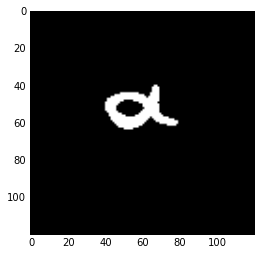

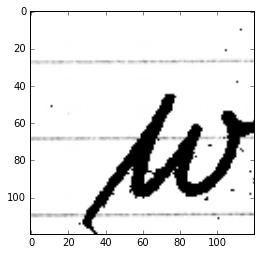

In [12]:
plt.imshow(1-X[4]/255.0, cmap='gray')
plt.figure()
plt.imshow(Xnoise, cmap='gray')

In [ ]:
Xnoisefft = np.fft.rfft2(Xnoise)
plt.imshow(Xnoisefft)